In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc

### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_drug_two_year'].values

In [3]:
#### CART
depth = [7,8,9]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [80]
depth = [2]
learning_rate = [0.3]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

### Lasso Stumps

In [4]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_drug_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns

In [6]:
### stumps model
alpha = [0.001]
Stump = stumps.stump_features(X_stumps, Y_stumps, cols, alpha, 816)

In [7]:
stumps.stump_table(Stump['coefs'], Stump['features'], Stump['intercept'], Stump['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| Gender>=1                         | 0.005          |
| age_at_current_charge<=38         | 0.001          |
| age_at_current_charge<=43         | 0.007          |
| age_at_current_charge<=46         | 0.001          |
| p_arrest>=2                       | 0.025          |
| p_arrest>=3                       | 0.025          |
| p_arrest>=4                       | 0.014          |
| p_arrest>=5                       | 0.02           |
| p_arrest>=6                       | 0.02           |
| p_felony>=2                       | -0.002         |
| p_misdemeanor>=1                  | 0.002          |
| p_misdemeanor>=3                  | 0.008          |
| p_drug>=1                         | 0.049          |
| p_drug>=2                         | 0.019          |
| p_stealing>=1                     | -0.006         |
| ADE>=1  

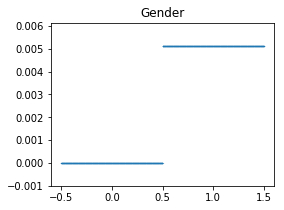

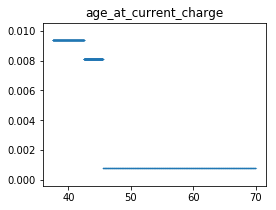

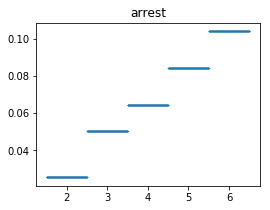

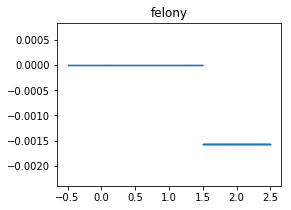

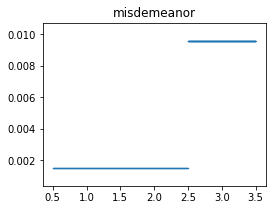

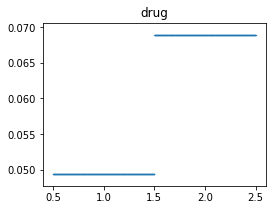

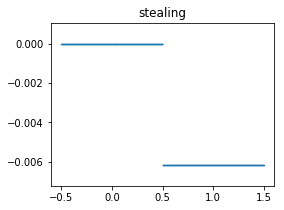

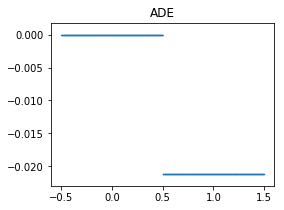

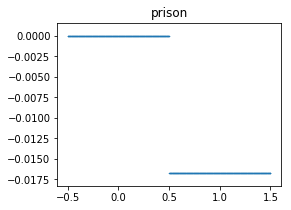

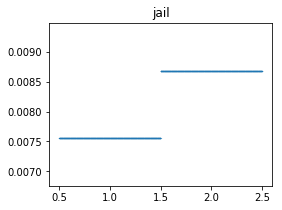

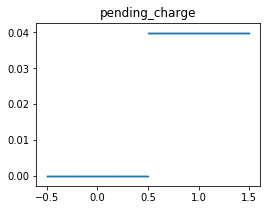

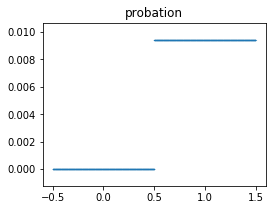

In [10]:
stumps.stump_plots(Stump['features'], Stump['coefs'])
pass

### Arnold PSA

In [11]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['nca_risk_score_raw'].values
X_arnold_calc = data['nca_calc'].values
Y_arnold = data['recid_drug_two_year'].values

In [12]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_fpr, raw_tpr, raw_thresholds = roc_curve(y_test, y_pred_raw)
    calc_fpr, calc_tpr, calc_thresholds = roc_curve(y_test, y_pred_calc)
    raw_auc.append(auc(raw_fpr, raw_tpr))
    calc_auc.append(auc(calc_fpr, calc_tpr))
    i+=1 

### Results

In [34]:
results = [["EBM", round(ebm_summary['best_validation_auc'],3), round(ebm_summary['best_validation_std'],3), ebm_summary['best_param']], 
           ['Lasso Stumps', round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3)], 
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]

In [35]:
results

[['AdaBoost',
  0.737772929611893,
  0.0016413846480892724,
  {'learning_rate': 1, 'n_estimators': 90}],
 ['EBM',
  0.7371781366966066,
  0.0032699681190166974,
  {'learning_rate': 0.3, 'max_tree_splits': 2, 'n_estimators': 80}],
 ['Lasso Stumps', 0.736, 0.002],
 ['Arnold PSA Raw', 0.697, 0.003],
 ['Arnold PSA', 0.688, 0.003]]

In [13]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Two Year/"
results = [["Drug", round(ebm_summary['best_validation_auc'],3), round(ebm_summary['best_validation_std'],3), round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3), round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3), round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]
with open(path + 'Two Year Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)